<a href="https://colab.research.google.com/github/Makiato1999/ECG-Detector/blob/main/anomaly_detection_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: True
Fri Dec  5 03:03:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   38C    P8             12W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os
from types import SimpleNamespace
from sklearn.metrics import f1_score, accuracy_score, recall_score

matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Download dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# Dataset: Segmented and Preprocessed ECG Signals for Heartbeat

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

Source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv

In [ ]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [ ]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


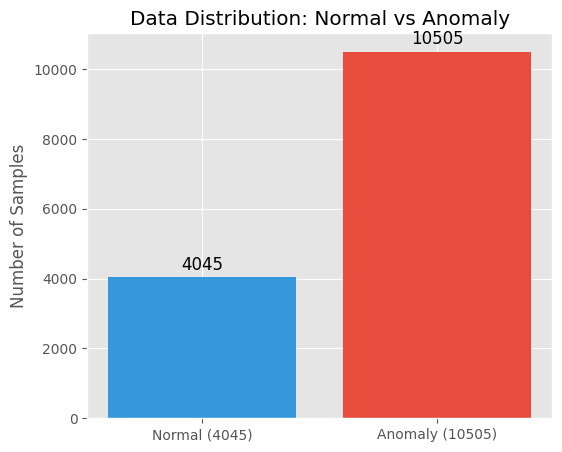

In [ ]:
'''
目的：在报告中坦白承认数据是不平衡的，并解释为什么这对 Autoencoder 没问题。
“虽然正常样本较少（约 4000），但足以覆盖标准心跳模式。大量的异常样本（约 10000）将作为极佳的测试集，验证模型的泛化能力。”
'''
# 准备数据
counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

# 在柱状图上标数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

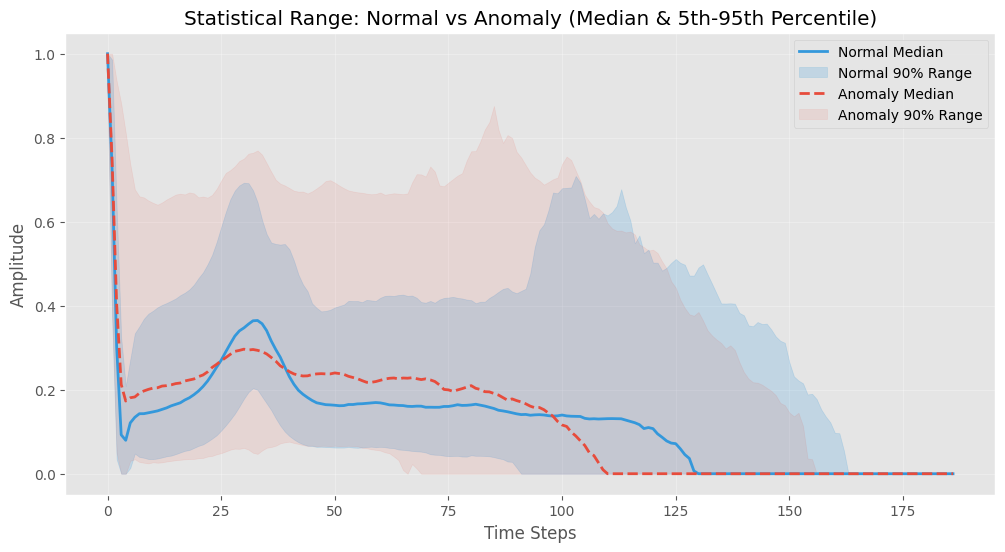

In [ ]:
'''
中位数 + 百分位区间 (Median + Percentile Range)

用中位数 (Median)。 既然标准差受分布影响大，我们就用90% 的数据分布区间 (5th - 95th Percentile)。
这样画出来的图，只会显示“大部分数据在哪里”，会过滤掉那些奇怪的 Padding 干扰。
去掉了奇怪的 spikes：因为中位数抗干扰能力强。
保留了 Range：阴影区域依然能让你对比出 Normal 的一致性 vs Anomaly 的混乱性。
'''
def plot_percentile_range(normal, anomaly):
    plt.figure(figsize=(12, 6))

    # 辅助函数：计算分位数
    def get_stats(df):
        # 50% 是中位数 (Median)
        median = np.nanpercentile(df, 50, axis=0)
        # 5% 和 95% 代表绝大多数数据的范围
        lower = np.nanpercentile(df, 5, axis=0)
        upper = np.nanpercentile(df, 95, axis=0)
        return median, lower, upper

    # 1. 计算 Normal 统计量
    norm_mid, norm_low, norm_high = get_stats(normal)

    # 2. 计算 Anomaly 统计量
    anom_mid, anom_low, anom_high = get_stats(anomaly)

    # 画 Normal (蓝色)
    plt.plot(norm_mid, color='#3498db', linewidth=2, label='Normal Median')
    plt.fill_between(range(187), norm_low, norm_high, color='#3498db', alpha=0.2, label='Normal 90% Range')

    # 画 Anomaly (红色)
    plt.plot(anom_mid, color='#e74c3c', linewidth=2, linestyle='--', label='Anomaly Median')
    plt.fill_between(range(187), anom_low, anom_high, color='#e74c3c', alpha=0.1, label='Anomaly 90% Range')

    plt.title("Statistical Range: Normal vs Anomaly (Median & 5th-95th Percentile)")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_percentile_range(normal_df, anomaly_df)

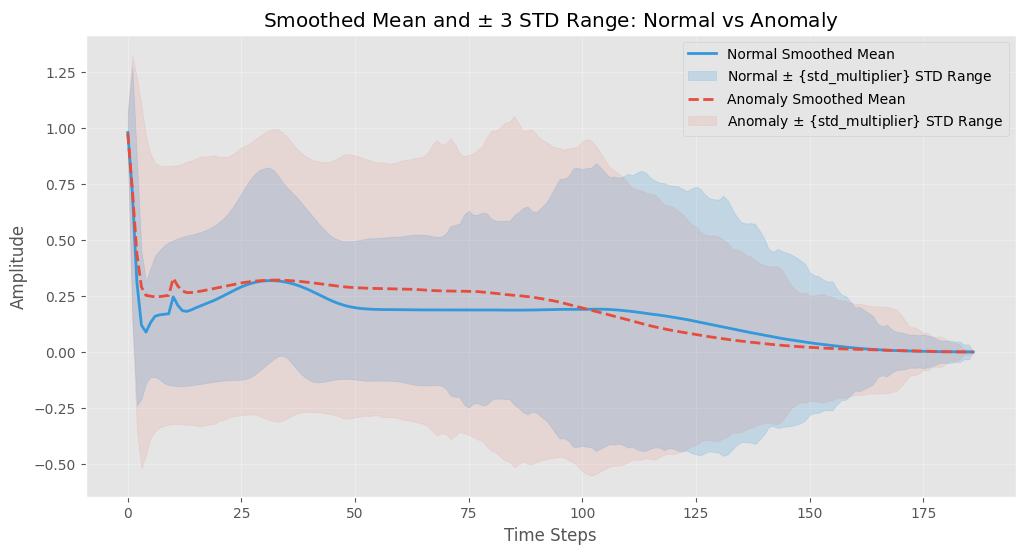

In [ ]:
time_steps = normal_df.shape[1] # 187

def calculate_smoothed_mean_stats_fixed(df, std_multiplier=3, window_size=20):
    r"""
    计算平滑均值线和原始数据的 $\pm$ STD 范围。
    """
    mean_signal = df.mean(axis=0)
    std_signal = df.std(axis=0)

    # 3. 对平均信号进行平滑处理 (这是中心线)
    smoothed_mean = mean_signal.rolling(window=window_size, center=True).mean()
    smoothed_mean = smoothed_mean.fillna(mean_signal)

    # 4. 计算基于原始标准差的上下限 (这是范围)
    upper_bound = mean_signal + std_signal * std_multiplier
    lower_bound = mean_signal - std_signal * std_multiplier

    return smoothed_mean.values, lower_bound.values, upper_bound.values

def plot_smoothed_range(normal_df, anomaly_df, std_multiplier=3, window_size=20):
    plt.figure(figsize=(12, 6))

    time_steps_range = range(normal_df.shape[1])

    # 1. 计算 Normal 统计量
    norm_mean, norm_low, norm_high = calculate_smoothed_mean_stats_fixed(
        normal_df, std_multiplier=std_multiplier, window_size=window_size
    )

    # 2. 计算 Anomaly 统计量
    anom_mean, anom_low, anom_high = calculate_smoothed_mean_stats_fixed(
        anomaly_df, std_multiplier=std_multiplier, window_size=window_size
    )

    # --- 绘制 Normal (蓝色) ---
    NORMAL_COLOR = '#3498db'

    # 中心线：平滑均值
    plt.plot(time_steps_range, norm_mean, color=NORMAL_COLOR, linewidth=2, label='Normal Smoothed Mean')

    # 范围阴影： +/- 3 STD 范围
    plt.fill_between(time_steps_range, norm_low, norm_high, color=NORMAL_COLOR, alpha=0.2, label=r'Normal $\pm$ {std_multiplier} STD Range')


    # --- 绘制 Anomaly (红色) ---
    ANOMALY_COLOR = '#e74c3c'

    # 中心线：平滑均值
    plt.plot(time_steps_range, anom_mean, color=ANOMALY_COLOR, linewidth=2, linestyle='--', label='Anomaly Smoothed Mean')

    # 范围阴影： +/- 3 STD 范围
    plt.fill_between(time_steps_range, anom_low, anom_high, color=ANOMALY_COLOR, alpha=0.1, label=r'Anomaly $\pm$ {std_multiplier} STD Range')


    # --- 设置图表样式 (与 percentile range 图表一致) ---
    plt.title(r"Smoothed Mean and $\pm$ 3 STD Range: Normal vs Anomaly")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_smoothed_range(normal_df, anomaly_df)

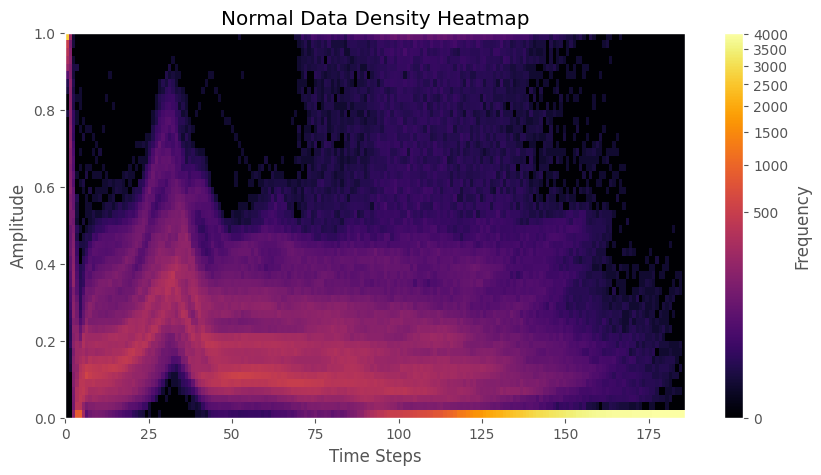

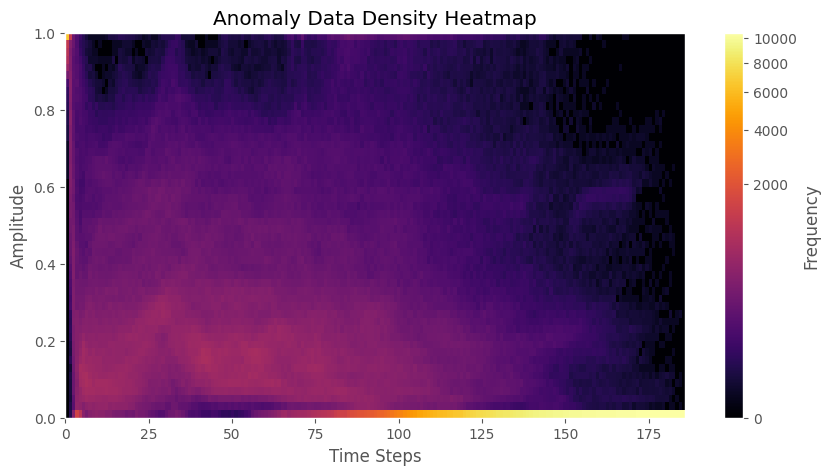

In [ ]:
'''
热力密度图 (2D Density Heatmap)

把所有心跳重叠在一起，哪个地方经过的线最多，哪个地方就最亮。
Normal 图：你应该能看到两个非常亮的红/黄色斑点（一个在左边，一个在中间）。这就完美证明了“Normal 数据有两种对齐模式”。
Anomaly 图：应该是一片雾蒙蒙的，没有特别集中的亮斑。
'''
import matplotlib.colors as mcolors

def plot_density_heatmap(df, title):
    # 准备数据：把 x 轴 (0-186) 和 y 轴 (数值) 摊平
    x = np.tile(np.arange(187), len(df))
    y = df.values.flatten()

    plt.figure(figsize=(10, 5))
    # 使用 hist2d 画热力图，bins 设置分辨率
    plt.hist2d(x, y, bins=[187, 50], cmap='inferno', norm=mcolors.PowerNorm(0.3))
    plt.colorbar(label='Frequency')
    plt.title(f"{title} Density Heatmap")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.show()

# 画 Normal 的热力图
plot_density_heatmap(normal_df, "Normal Data")

# 画 Anomaly 的热力图
plot_density_heatmap(anomaly_df, "Anomaly Data")

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


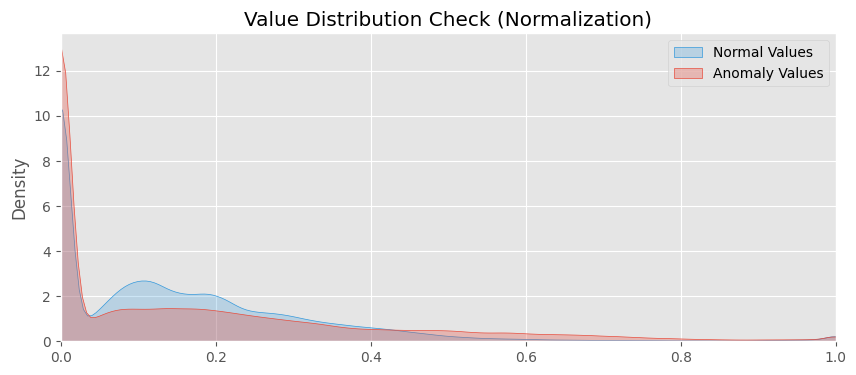

In [ ]:
'''
数据已归一化至 [0, 1] 区间，且分布集中。这决定了我们的 Autoencoder 将使用 Sigmoid 激活函数作为输出层
'''
# 快速检查
print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

# 画个简单的分布直方图
plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

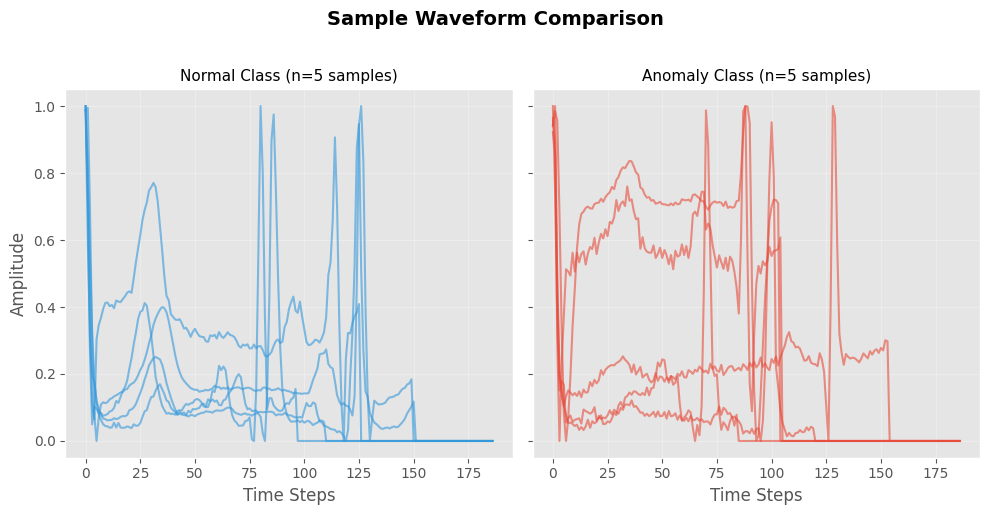

In [ ]:
"""
使用少量样本的叠加（Overlay）来可视化 Normal 和 Anomaly 数据的波形。
"""
def plot_sample_overlay(normal_df, anomaly_df, n_samples=5, title="Sample Waveform Comparison"):

    # 随机选择索引
    # 确保样本数量不会超过数据集中实际的样本数
    n_normal = min(n_samples, len(normal_df))
    n_anomaly = min(n_samples, len(anomaly_df))

    normal_indices = np.random.randint(0, len(normal_df), n_normal)
    anomaly_indices = np.random.randint(0, len(anomaly_df), n_anomaly)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    # --- 左图：Normal Data (蓝色) ---
    NORMAL_COLOR = '#3498db'

    # 叠加绘制 Normal 样本
    for i, idx in enumerate(normal_indices):
        # 使用较高的透明度 (alpha=0.6) 以保证每条线可见，但重叠可见
        label = f"Sample {idx}" if i == 0 else None # 只给第一条线标签，避免图例过长
        ax[0].plot(normal_df.iloc[idx, :].values, color=NORMAL_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[0].set_title(f"Normal Class (n={n_normal} samples)", fontsize=11)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid(True, alpha=0.3)
    # 移除图例，因为叠加时图例太多会混乱
    # ax[0].legend(loc='upper right', fontsize=9)

    # --- 右图：Anomaly Data (红色) ---
    ANOMALY_COLOR = '#e74c3c'

    # 叠加绘制 Anomaly 样本
    for i, idx in enumerate(anomaly_indices):
        label = f"Sample {idx}" if i == 0 else None
        ax[1].plot(anomaly_df.iloc[idx, :].values, color=ANOMALY_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[1].set_title(f"Anomaly Class (n={n_anomaly} samples)", fontsize=11)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.3)
    # ax[1].legend(loc='upper right', fontsize=9)

    plt.suptitle(title, fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_sample_overlay(normal_df, anomaly_df, n_samples=5)

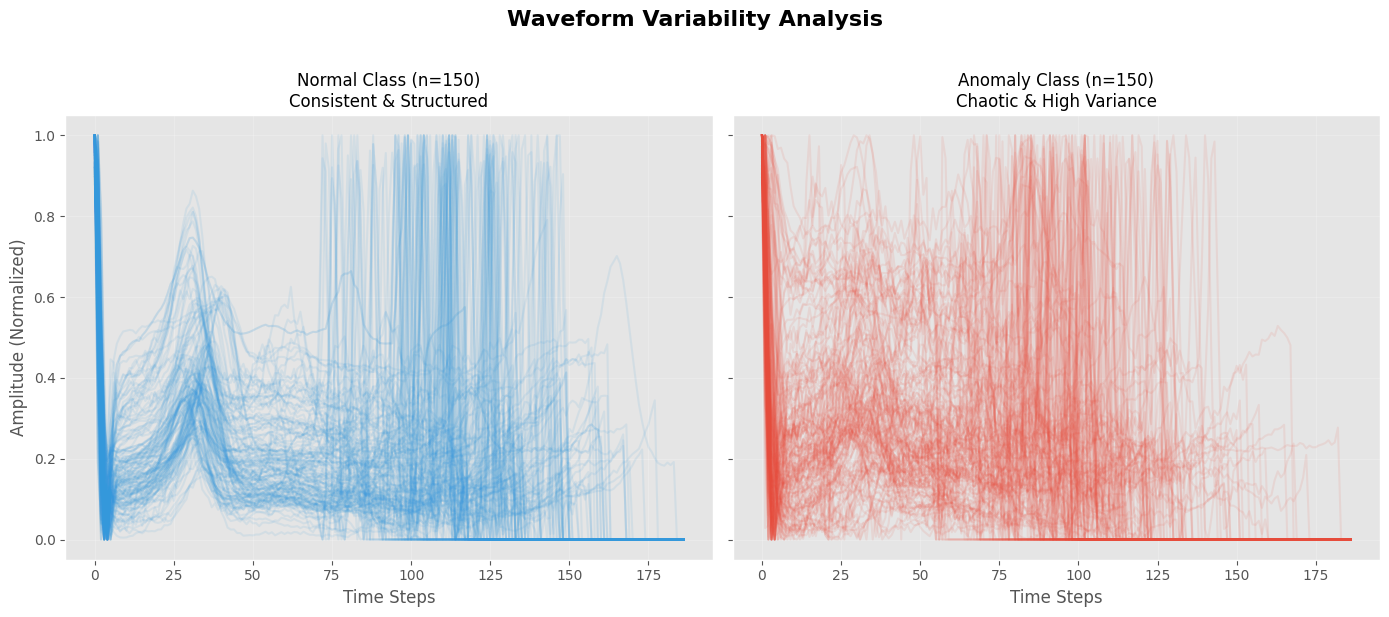

In [ ]:
"""
    使用叠加法可视化 ECG 数据的规律性 vs 混乱度
"""
def plot_waveform_overlay(normal, anomaly, n_samples=150, title="Waveform Variability Analysis"):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

    # --- 左图：Normal Data (蓝色) ---
    # 随机取样
    normal_indices = np.random.randint(0, len(normal), n_samples)

    # 循环画线，alpha 设置很低(0.1)，让重叠部分显现出来
    for i in normal_indices:
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.1, linewidth=1.5)

    ax[0].set_title(f"Normal Class (n={n_samples})\nConsistent & Structured", fontsize=12)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude (Normalized)")
    ax[0].grid(True, alpha=0.2) # 网格淡一点，不要抢戏

    # --- 右图：Anomaly Data (红色) ---
    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)

    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.1, linewidth=1.5)

    ax[1].set_title(f"Anomaly Class (n={n_samples})\nChaotic & High Variance", fontsize=12)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.2)

    plt.suptitle(title, fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_waveform_overlay(normal_df, anomaly_df, n_samples=150)

# Configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    epochs: int = 50
    learning_rate: float = 0.001
    batch_size: int = 64
    use_augmentation: bool = False
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_path: str = './checkpoints'
    model_name: str = 'best_autoencoder.pth'

# Normal-only Scaler

1.对优化更友好

  每一维特征都大致是零均值，梯度传播更稳定；

  不会出现某些 time-step 只在小范围抖动，非常“扁平”。

2.对异常检测更清晰

  normal 的误差分布会更集中在一个统一尺度；

  anomaly 更容易在这个尺度上“冲出去”。

In [ ]:
normal = normal_df.to_numpy().astype(np.float64)
anomaly = anomaly_df.to_numpy().astype(np.float64)

In [ ]:
from types import SimpleNamespace

def split_normal_data(normal, anomaly, seed=45):
    X_train, X_temp = train_test_split(
        normal, test_size=0.30, random_state=seed, shuffle=True
    )

    X_validate, X_test = train_test_split(
        X_temp, test_size=0.50, random_state=seed, shuffle=True
    )

    return SimpleNamespace(
        train=X_train,
        val=X_validate,
        test=X_test,
        anomaly=anomaly
    )

data_split = split_normal_data(normal, anomaly)

X_train = data_split.train
X_validate = data_split.val
X_test = data_split.test
anomaly = data_split.anomaly
print("Train:", X_train.shape)
print("Valid:", X_validate.shape)
print("Test :", X_test.shape)

Train: (2831, 187)
Valid: (607, 187)
Test : (607, 187)


In [ ]:
# Normal-only Scaler
from sklearn.preprocessing import StandardScaler
from types import SimpleNamespace

def scaler_data(X_train, X_validate, X_test, anomaly):
  scaler = StandardScaler()
  scaler.fit(X_train)   # 只用 normal 训练集拟合

  X_train_scaled    = scaler.transform(X_train)
  X_validate_scaled = scaler.transform(X_validate)
  X_test_scaled     = scaler.transform(X_test)
  anomaly_scaled    = scaler.transform(anomaly)

  print("Train:", X_train_scaled.shape)
  print("Valid:", X_validate_scaled.shape)
  print("Test :", X_test_scaled.shape)

  return SimpleNamespace(
      X_train_scaled,
      X_validate_scaled,
      X_test_scaled,
      anomaly_scaled
  )

In [ ]:
class AnomalyDetectionDataset(Dataset):
    """
    PyTorch Dataset for Autoencoder Anomaly Detection.
    X = Y = input itself.
    """
    def __init__(self, np_array):
        self.data = torch.from_numpy(np_array).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x   # 自编码器需要 X=Y

In [ ]:
def get_datasets(data_split, use_scaled = False):
  if use_scaled:
    scaled = scaler_data(
        data_split.train,
        data_split.val,
        data_split.test,
        data_split.anomaly
    )
    X_train = scaled.X_train_scaled
    X_val   = scaled.X_validate_scaled
    X_test  = scaled.X_test_scaled
    anomaly = scaled.anomaly_scaled
  else:
    X_train = data_split.train
    X_val   = data_split.val
    X_test  = data_split.test
    anomaly = data_split.anomaly

  train_ds = AnomalyDetectionDataset(X_train)
  val_ds   = AnomalyDetectionDataset(X_val)
  test_ds  = AnomalyDetectionDataset(X_test)
  anom_ds  = AnomalyDetectionDataset(anomaly)

  return SimpleNamespace(
      train=train_ds,
      val=val_ds,
      test=test_ds,
      anomaly=anom_ds
  )

In [ ]:
# 6. DataLoaders
BATCH_SIZE = 64

datasets = get_datasets(data_split, use_scaled=False)

train_dataset = datasets.train
validate_dataset = datasets.val
test_dataset = datasets.test
anomaly_dataset = datasets.anomaly

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Valid batches:", len(validate_loader))
print("Test batches :", len(test_loader))
print("Anomaly batches:", len(anomaly_loader))

Train batches: 45
Valid batches: 10
Test batches : 10
Anomaly batches: 165


# Normal-only Data Augmentation
好处 1: 减少误报

normal 的误差分布会变得更集中且更低。

好处 2: 真正的 anomaly 会更突出

因为 AE 见过“正常的变化”，它不会被小噪声骗到；
只有 “真正离谱的” 才会变成稳定的大 reconstruction error

In [ ]:
import random

def augment_ecg(batch, jitter_std=0.01, scale_std=0.05, max_shift=2):
    """
    batch: (B, 188)
    """
    B, T = batch.shape

    # 1. jitter 小噪声
    jitter = torch.randn_like(batch) * jitter_std
    batch = batch + jitter

    # 2. scaling 幅度缩放
    # scale = 1.0 + torch.randn(B, 1, device=batch.device) * scale_std
    scale = 1.0 + torch.randn_like(batch[:, :1]) * scale_std
    batch = batch * scale

    # 3. small time shift 小平移
    shift = random.randint(-max_shift, max_shift)
    batch = torch.roll(batch, shifts=shift, dims=1)

    return batch


# CNN Autoencoder Model

In [ ]:
class ECG_AutoEncoder_K(nn.Module):
    def __init__(self):
        super().__init__()
        # 对应 Keras: latent_dim = 32

        # --- Encoder ---
        self.encoder = nn.Sequential(
            # 1. Reshape done in forward (unsqueeze)

            # 2. Conv1D(128, 3, strides=1, padding="same")
            nn.Conv1d(1, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # MaxPooling1D(2, padding="same") -> Keras对于奇数会向上取整，PyTorch需要 ceil_mode=True
            # 187 -> 94
            nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True),

            # 3. Conv1D(128, 3, strides=1, padding="same")
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # MaxPool 94 -> 47
            nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True),

            # 4. Conv1D(latent_dim=32, 3, strides=1, padding="same")
            nn.Conv1d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            # MaxPool 47 -> 24
            nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True),
        )

        # --- Decoder ---
        # 他的代码里注释掉了 UpSampling，只用了 Conv1DTranspose(strides=1)
        # 这意味着他在 Decoder 阶段没有把时间维度(24)变大，而是留给了最后的 Dense 层去“硬算”
        self.decoder_layers = nn.Sequential(
            # Conv1DTranspose(32, 3, strides=1, padding="same")
            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # Conv1DTranspose(128, 3, strides=1, padding="same")
            nn.ConvTranspose1d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            # Conv1DTranspose(128, 3, strides=1, padding="same")
            nn.ConvTranspose1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # --- Output Head ---
        # Keras: Flatten() + Dense(input_dim)
        # 输入维度计算: Encoder输出长度是 24, 通道是 128
        # 所以 Flatten 之后是 24 * 128 = 3072
        self.flatten_dim = 24 * 128

        self.dense_out = nn.Linear(self.flatten_dim, 187)
        # 注意: 原作 Keras 代码里 Dense 没有指定 activation，默认是 Linear
        # 也没有加 Sigmoid。为了完全复刻，我这里也不加 Sigmoid。

    def forward(self, x):
        # x: (Batch, 187)
        x = x.unsqueeze(1) # -> (Batch, 1, 187)

        # Encoding
        x = self.encoder(x)
        # 此时形状应该是 (Batch, 32, 24)

        # Decoding (Feature Processing)
        x = self.decoder_layers(x)
        # 此时形状应该是 (Batch, 128, 24)

        # Flatten
        x = x.view(x.size(0), -1) # -> (Batch, 3072)

        # Dense Projection
        x = self.dense_out(x) # -> (Batch, 187)

        return x

In [ ]:
def train_model(model, train_loader, val_loader, config: Config):
    device = torch.device(config.device)
    model = model.to(device)

    # 优化器使用 config 中的学习率
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.L1Loss()

    # 初始化用于记录 Loss 的字典 (为了最后画图用)
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')

    print(f"Start training on {config.device} for {config.epochs} epochs...")

    for epoch in range(config.epochs):

        # --- Training Phase ---
        model.train()
        train_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            # 使用 config.device
            data = data.to(config.device)

            # 使用 config.use_augmentation
            if config.use_augmentation:
                # 假设 augment_ecg 是你定义好的函数
                data_aug = augment_ecg(data).to(config.device)
            else:
                data_aug = data

            optimizer.zero_grad()
            outputs = model(data_aug)
            loss = criterion(outputs, data) # 注意：Target 通常是原始未增强的数据
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch, _ in val_loader:
                batch = batch.to(config.device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            # 确保目录存在，不存在则创建
            if not os.path.exists(config.save_path):
                os.makedirs(config.save_path)

            # 拼接完整路径
            save_full_path = os.path.join(config.save_path, config.model_name)

            torch.save(model.state_dict(), save_full_path)
            print(f"  >>> Best model saved to {save_full_path}!")

    print("Training Complete.")
    return history

🚀 Training Started...
Start training on cuda for 50 epochs...
Epoch [1/50] Train Loss: 0.152166 | Val Loss: 0.078400
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [2/50] Train Loss: 0.058474 | Val Loss: 0.050143
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [3/50] Train Loss: 0.046620 | Val Loss: 0.050895
Epoch [4/50] Train Loss: 0.043528 | Val Loss: 0.049692
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [5/50] Train Loss: 0.041476 | Val Loss: 0.038224
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [6/50] Train Loss: 0.031237 | Val Loss: 0.028587
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [7/50] Train Loss: 0.032681 | Val Loss: 0.026818
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [8/50] Train Loss: 0.027641 | Val Loss: 0.024047
  >>> Best model saved to ./checkpoints/best_autoencoder.pth!
Epoch [9/50] Train Loss: 0.027048 | Val Loss: 0.030467
Epoch [10

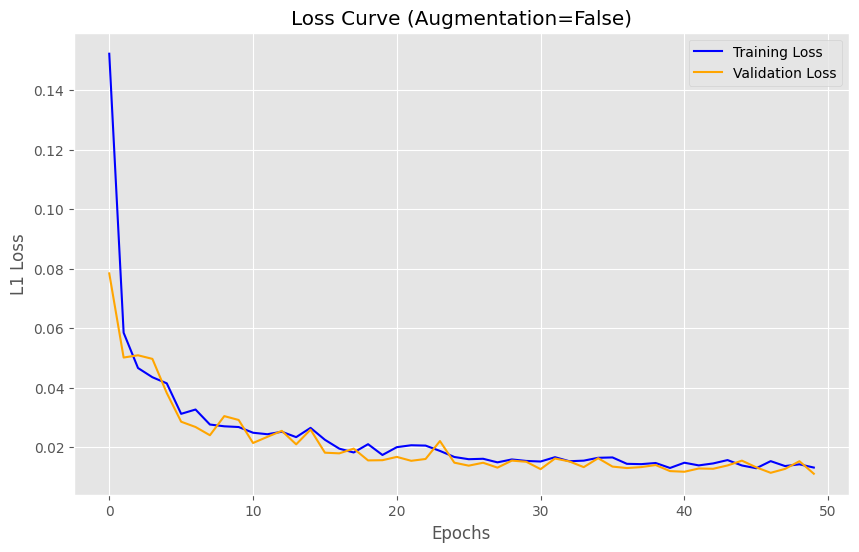

In [ ]:
config = Config(
    epochs=50,
    learning_rate=0.001,
    batch_size=64,
    use_augmentation=False,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
model = ECG_AutoEncoder_K()
print("🚀 Training Started...")
history = train_model(model, train_loader, validate_loader, config)

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss Curve (Augmentation={config.use_augmentation})')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.grid(True)
plt.show()

>>> 模型加载完成。
正在计算 Validation Set (Normal) 误差...
正在计算 Anomaly Set 误差...
正在计算 Test Set (Normal) 误差...
统计学阈值 (Mean + 1*STD): 0.01551


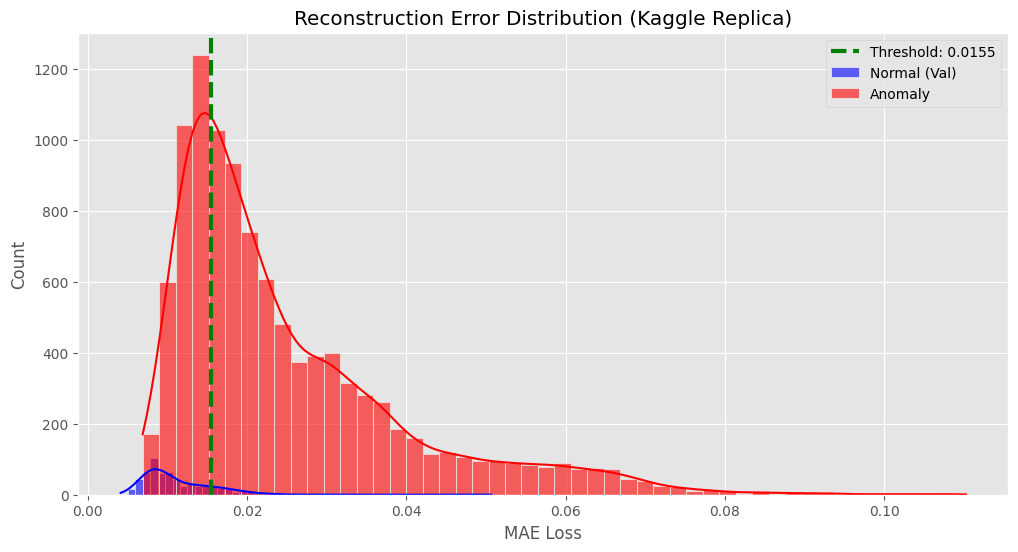


=== 最终测试结果 ===
Normal Test Accuracy: 89.13%
Anomaly Recall:       69.19%


In [ ]:
# --- 确保工具函数是最新的 (无 Scaler 版本) ---
def get_losses(model, loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(config.device)
            # 1. 模型预测
            reconstruction = model(batch)
            # 2. 直接计算 MAE (Input 和 Output 都在 0-1 之间)
            loss = torch.mean(torch.abs(batch - reconstruction), dim=1)
            losses.extend(loss.cpu().numpy())
    return np.array(losses)

def find_threshold_statistical(normal_losses):
    """
    Kaggle 常用简单策略：
    基于 Normal 数据的分布，设定阈值为 Mean + 1 * STD。
    (Mean + 2*STD 会更严格，Acc更高但Recall更低；Mean + 1*STD Recall更高)
    """
    mean_loss = np.mean(normal_losses)
    std_loss = np.std(normal_losses)

    # 设定阈值: 均值 + 1倍标准差 (为了高 Recall)
    threshold = mean_loss + 1.0 * std_loss

    print(f"统计学阈值 (Mean + 1*STD): {threshold:.5f}")
    return threshold

# 1. 加载训练好的最佳模型
# 确保你已经实例化了模型: model = Kaggle_Redpen12_Exact().to(device)
model.load_state_dict(torch.load(config.save_path + "/" + config.model_name))
model.eval()
print(">>> 模型加载完成。")

# 2. 计算各个数据集的重建误差 (Loss)
print("正在计算 Validation Set (Normal) 误差...")
val_losses = get_losses(model, validate_loader)

print("正在计算 Anomaly Set 误差...")
anomaly_losses = get_losses(model, anomaly_loader)

print("正在计算 Test Set (Normal) 误差...")
test_losses = get_losses(model, test_loader)

# 3. 使用简单统计阈值 (不要用 F1 寻找了)
best_threshold = find_threshold_statistical(val_losses)

# 4. 可视化直方图 (见证奇迹的时刻)
plt.figure(figsize=(12, 6))
# 画 Normal (Validation)
sns.histplot(val_losses, bins=50, kde=True, color='blue', label='Normal (Val)', alpha=0.6)
# 画 Anomaly (全部数据)
sns.histplot(anomaly_losses, bins=50, kde=True, color='red', label='Anomaly', alpha=0.6)
# 画阈值线
plt.axvline(best_threshold, color='green', linestyle='--', linewidth=3, label=f'Threshold: {best_threshold:.4f}')

plt.title("Reconstruction Error Distribution (Kaggle Replica)")
plt.xlabel("MAE Loss")
plt.legend()
plt.show()

# 5. 最终测试集表现 (Reality Check)
print("\n=== 最终测试结果 ===")

# Normal Test Accuracy (应该 > 90%)
normal_pred = (test_losses <= best_threshold).astype(int) # 注意这里是 <= 阈值算正常
normal_acc = np.mean(normal_pred)

# Anomaly Recall (应该 > 90%)
anomaly_pred = (anomaly_losses > best_threshold).astype(int) # > 阈值算异常
anomaly_recall = np.mean(anomaly_pred)

print(f"Normal Test Accuracy: {normal_acc:.2%}")
print(f"Anomaly Recall:       {anomaly_recall:.2%}")

正在使用您的模型和验证集数据生成重建结果...
开始绘图...


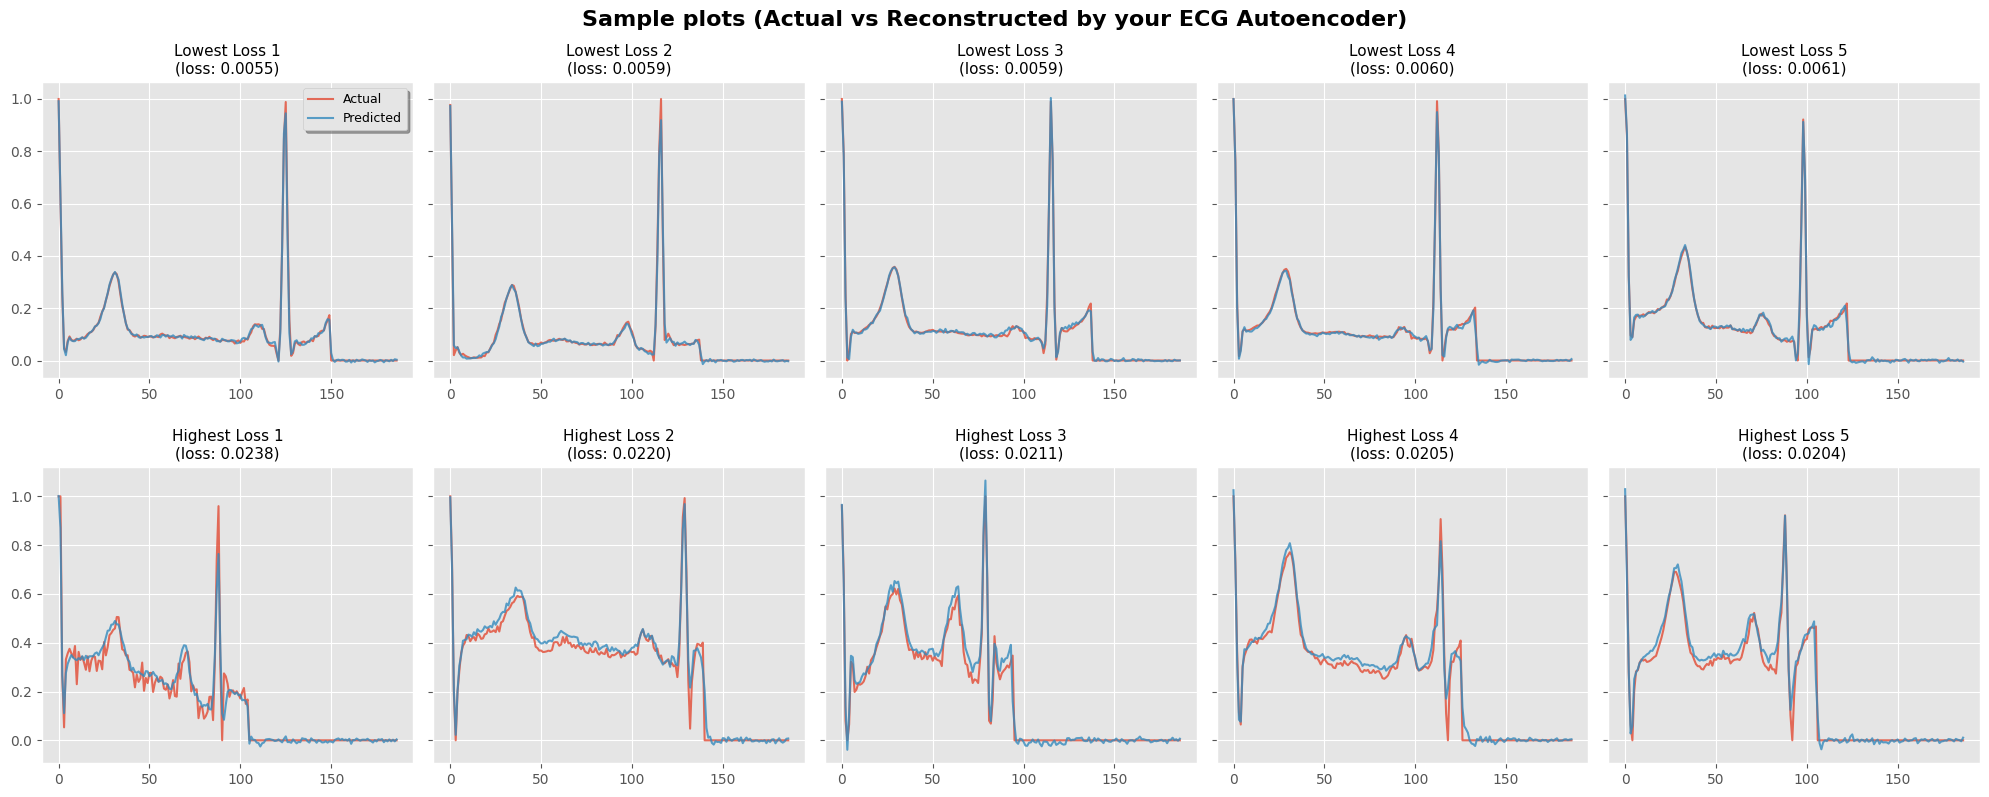

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ==========================================
# 1. 准备工作：获取真实数据和模型预测
# ==========================================
def get_real_data_and_reconstructions(model, val_loader, config):
    """
    从验证集获取真实数据，并使用模型生成重建数据和计算Loss。
    """
    model.eval() # 切换到评估模式
    device = torch.device(config.device)
    model = model.to(device)

    all_actual = []
    all_predicted = []
    all_losses = []

    criterion = torch.nn.L1Loss(reduction='none') # 计算每个点的Loss，不求平均

    print("正在使用您的模型和验证集数据生成重建结果...")
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            # 将数据移动到设备
            data = data.to(device)

            # 模型前向传播，获取重建结果
            reconstructed = model(data)

            # 计算该批次每个样本的平均 L1 Loss
            # loss shape: (batch_size, sequence_length) -> mean(dim=1) -> (batch_size,)
            loss_batch = torch.mean(criterion(reconstructed, data), dim=1)

            # 将数据移回 CPU 并转为 numpy
            all_actual.append(data.cpu().numpy())
            all_predicted.append(reconstructed.cpu().numpy())
            all_losses.append(loss_batch.cpu().numpy())

            # 为了演示，我们只取前几个 batch 就够了，避免数据量太大
            if batch_idx >= 2:
                break

    # 将所有 batch 的数据拼接起来
    # X_actual.shape 和 X_predicted.shape 将会是 (N_samples, 140)
    # losses.shape 将会是 (N_samples,)
    X_actual = np.concatenate(all_actual, axis=0)
    X_predicted = np.concatenate(all_predicted, axis=0)
    losses = np.concatenate(all_losses, axis=0)

    return X_actual, X_predicted, losses

# ==========================================
# 2. 核心绘图函数 (2x5 网格)
# ==========================================
def plot_results_grid(normal_samples, anomaly_samples):
    """
    绘制 2x5 的组图对比真实值与预测值。
    normal_samples, anomaly_samples 都是包含 (actual, pred, loss) 元组的列表。
    """
    plt.style.use('ggplot') # 使用 ggplot 风格
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey='row')

    # 设置总标题
    fig.suptitle('Sample plots (Actual vs Reconstructed by your ECG Autoencoder)',
                 fontsize=16, fontweight='bold', y=0.99)

    color_actual = '#E24A33'  # 红色
    color_predicted = '#348ABD' # 蓝色

    # --- 绘制第一行：Loss 最低的样本 (代表 "Normal") ---
    for i in range(5):
        ax = axes[0, i]
        actual, predicted, loss = normal_samples[i]

        ax.plot(actual, color=color_actual, label='Actual', linewidth=1.5, alpha=0.8)
        ax.plot(predicted, color=color_predicted, label='Predicted', linewidth=1.5, alpha=0.8)

        ax.set_title(f'Lowest Loss {i+1}\n(loss: {loss:.4f})', fontsize=11)
        if i == 0:
             ax.legend(loc='best', shadow=True, fancybox=True, prop={'size': 9})

    # --- 绘制第二行：Loss 最高的样本 (代表 "Potential Anomaly") ---
    for i in range(5):
        ax = axes[1, i]
        actual, predicted, loss = anomaly_samples[i]

        ax.plot(actual, color=color_actual, label='Actual', linewidth=1.5, alpha=0.8)
        ax.plot(predicted, color=color_predicted, label='Predicted', linewidth=1.5, alpha=0.8)

        ax.set_title(f'Highest Loss {i+1}\n(loss: {loss:.4f})', fontsize=11)

    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.3) # 调整顶部和子图间距
    plt.show()

# ==========================================
# 🚀 执行脚本
# ==========================================
# 1. 获取真实数据、重建数据和对应的 Loss
# 假设 model, val_loader, config 已经在你的环境中定义好了
X_actual, X_predicted, losses = get_real_data_and_reconstructions(model, validate_loader, config)

# 2. 根据 Loss 对样本进行排序，挑选出 Loss 最低和最高的样本
# argsort 返回的是排序后的索引
sorted_indices = np.argsort(losses)

# 挑选 Loss 最低的 5 个样本 (作为 "Normal" 示例)
normal_indices = sorted_indices[:5]
normal_samples_list = []
for idx in normal_indices:
    normal_samples_list.append((X_actual[idx], X_predicted[idx], losses[idx]))

# 挑选 Loss 最高的 5 个样本 (作为 "Anomaly" 示例)
# 使用 [-5:] 取最后 5 个，并用 [::-1] 反转顺序，这样第一个就是 loss 最高的
anomaly_indices = sorted_indices[-5:][::-1]
anomaly_samples_list = []
for idx in anomaly_indices:
    anomaly_samples_list.append((X_actual[idx], X_predicted[idx], losses[idx]))

# 3. 调用绘图函数
print("开始绘图...")
plot_results_grid(normal_samples_list, anomaly_samples_list)

In [ ]:
def compute_raw_mae(model, loader, scaler, device="cuda"):
    model.eval()
    mae_list = []

    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.to(device)

            # ---- AE 重建（在 scaled 空间）----
            recon = model(batch)           # (B,187)

            # ---- 转成 numpy ----
            orig = batch.cpu().numpy()     # scaled space
            recon = recon.cpu().numpy()

            # ---- inverse transform 回 raw space ----
            orig_raw = scaler.inverse_transform(orig)
            recon_raw = scaler.inverse_transform(recon)

            # ---- MAE in raw space ----
            mae = np.mean(np.abs(orig_raw - recon_raw), axis=1)  # 每条样本一个 MAE
            mae_list.append(mae)

    mae_list = np.concatenate(mae_list)
    return mae_list


In [ ]:
raw_mae_normal = compute_raw_mae(model, test_loader, scaler)
print("Mean raw-space MAE on normal test:", raw_mae_normal.mean())


In [ ]:
raw_mae_anomaly = compute_raw_mae(model, anomaly_loader, scaler)
print("Mean raw-space MAE on anomaly:", raw_mae_anomaly.mean())


In [ ]:
plt.hist(raw_mae_normal, bins=50, alpha=0.6, label="Normal")
plt.hist(raw_mae_anomaly, bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Reconstruction Error in Raw Feature Space")
plt.show()
